In [1]:
# Declaring path variables to make Basemap work in jupyter hub. Make sure that the conda environment path matches yours
import os
os.environ['PATH'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/bin:' + os.environ['PATH']
os.environ['PROJ_LIB'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/share/proj'

In [2]:
# General Tool Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap
import biota
import biota.plot as bpl
import seaborn as sns
import collections
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import math

from biota.database import (get_samples,
                            get_sample_data,
                            get_pg_connection,
                            get_data)
from biota.util import (rarefy,
                        make_tree,
                        get_dms,
                        filter_dm_and_map,
                        get_tax_table)
from IPython.core.display import display, HTML
from pickle import dump, load

import lasio

# SQL Query imports
from sqlalchemy import create_engine, engine, inspect

from functools import partial

from ipyparallel import Client
from sourcetracker import gibbs

# Clustering imports
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from skbio.stats.ordination import pcoa

from biota.util import assign_formations

%matplotlib inline

In [3]:
Logs = lasio.read("Range_Weyer_15_2_GEM_interpV2.las")

In [4]:
Logs.keys()

['DEPT',
 'GR',
 'RT90',
 'RT10',
 'RT',
 'RXO',
 'NLIM',
 'CALI',
 'RHOB',
 'DRHO',
 'PE',
 'TENS',
 'LSPD',
 'BS',
 'VWF',
 'VGAS',
 'VCBW',
 'QRTZ',
 'CALC',
 'DOLO',
 'KFEL',
 'NFEL',
 'PYRT',
 'ILLI',
 'FECL',
 'DWPQ',
 'DWPC',
 'DWPD',
 'DWPK',
 'DWNF',
 'DWPP',
 'DWPI',
 'DWFC',
 'RINC',
 'ROMA',
 'PHIT',
 'PHIE',
 'SWE',
 'SWT',
 'VCL',
 'DMG',
 'DAL',
 'DSI',
 'DSUL',
 'DK',
 'DCA',
 'DTI',
 'DMN',
 'DFE',
 'DGD',
 'WMG',
 'WAL',
 'WSI',
 'WSUL',
 'WK',
 'WCA',
 'WTI',
 'WMN',
 'WFE',
 'WGD',
 'GPE',
 'GRTO',
 'GRTC',
 'POTA',
 'URAN',
 'THOR']

In [5]:
Logs.header

{'Version': [HeaderItem(mnemonic=VERS, unit=, value=2.0, descr=CWLS log ASCII Standard -V...),
  HeaderItem(mnemonic=WRAP, unit=, value=NO, descr=One line per depth step)],
 'Well': [HeaderItem(mnemonic=STRT, unit=F, value=10990.0, descr=START DEPTH),
  HeaderItem(mnemonic=STOP, unit=F, value=13906.0, descr=STOP DEPTH),
  HeaderItem(mnemonic=STEP, unit=F, value=0.25, descr=STEP DEPTH),
  HeaderItem(mnemonic=NULL, unit=, value=-999.25, descr=NULL VALUE),
  HeaderItem(mnemonic=SON, unit=, value=904109112, descr=JOB NUMBER),
  HeaderItem(mnemonic=SECT, unit=, value=15, descr=SECTION),
  HeaderItem(mnemonic=TOWN, unit=, value=16N, descr=TOWNSHIP),
  HeaderItem(mnemonic=RANG, unit=, value=1W, descr=RANGE),
  HeaderItem(mnemonic=UWI, unit=, value=170492083400, descr=UNIQUE WELL IDENTI...),
  HeaderItem(mnemonic=API, unit=, value=170492083400, descr=API NUMBER),
  HeaderItem(mnemonic=BASI, unit=, value=BACIA, descr=BASIN),
  HeaderItem(mnemonic=HIDE, unit=, value=, descr=WELLNAMEOPERAT),
  He

In [6]:
print(Logs.curves.RHOB.data)

[2.692  2.6952 2.6949 ... 2.6329 2.6305 2.6236]


In [7]:
Logs.curves.RHOB.data.shape

(11665,)

In [8]:
Logs.curves.DEPT.data.shape

(11665,)

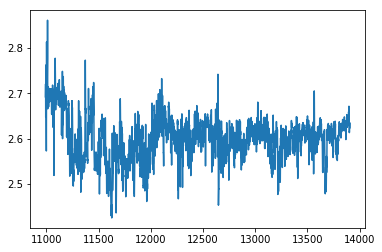

In [9]:
plt.plot(Logs.index,Logs["RHOB"])

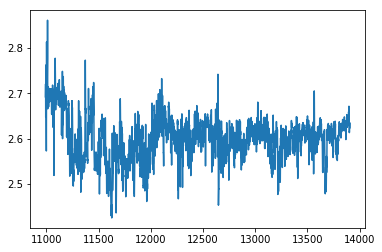

In [10]:
plt.plot(Logs["DEPT"],Logs["RHOB"])

In [11]:
Logs["SYN"] = Logs["RHOB"]*Logs["GR"]    

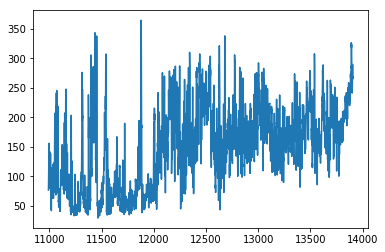

In [12]:
plt.plot(Logs.index,Logs["SYN"])

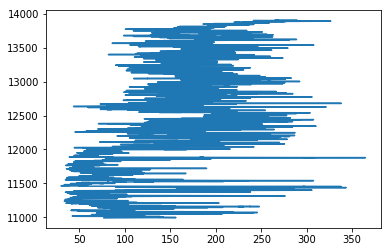

In [13]:
plt.plot(Logs["SYN"],Logs.index)

In [14]:
df = Logs.df() 

In [15]:
df.head()

,GR,RT90,RT10,RT,RXO,NLIM,CALI,RHOB,DRHO,PE,...,WMN,WFE,WGD,GPE,GRTO,GRTC,POTA,URAN,THOR,SYN
DEPT,,,,,,,,,,,,,,,,,,,,,
10990.00,28.5660,22.4923,30.2969,22.4459,31.7597,0.0815,10.0087,2.6920,-0.0246,5.0471,...,0.0,0.0152,0.0015,3.5777,49.1123,36.0285,1.2314,1.7881,5.0153,76.899672
10990.25,29.0288,18.8745,23.1374,18.8424,23.9836,0.0952,10.0066,2.6952,-0.0253,5.2001,...,0.0,0.0157,0.0030,3.5213,52.7523,38.6722,1.3487,1.8709,5.2490,78.238422
10990.50,29.4236,16.4680,18.9027,16.4441,19.4770,0.1121,10.0196,2.6949,-0.0306,5.5896,...,0.0,0.0158,0.0130,3.4440,56.6330,41.6026,1.4679,1.9861,5.5567,79.293660
10990.75,30.4836,13.4729,14.7268,13.4573,15.0794,0.1382,10.0668,2.6932,-0.0418,6.4211,...,0.0,0.0157,0.0411,3.3601,60.7631,44.5056,1.5776,2.1400,5.8997,82.098432
10991.00,31.6252,9.5708,10.1617,9.5632,10.3225,0.1765,10.1082,2.6955,-0.0546,7.6480,...,0.0,0.0153,0.1097,3.2922,65.1827,47.4354,1.6761,2.2924,6.3019,85.245727


In [163]:
df_gr = df.loc[:,'RHOB'].to_frame()

In [195]:
df_syn = df.loc[:,['GR','RT']]

In [177]:
df_gr.head()

,RHOB
DEPT,
10990.00,2.6920
10990.25,2.6952
10990.50,2.6949
10990.75,2.6932
10991.00,2.6955


In [201]:
df_syn.head()

,GR,RT
DEPT,,
10990.00,28.5660,22.4459
10990.25,29.0288,18.8424
10990.50,29.4236,16.4441
10990.75,30.4836,13.4573
10991.00,31.6252,9.5632


In [213]:
df_syn.head()

#foo = df_syn["GR"] * df_syn.iloc[1,0]
#foo

,GR,RT
DEPT,,
10990.00,28.5660,22.4459
10990.25,29.0288,18.8424
10990.50,29.4236,16.4441
10990.75,30.4836,13.4573
10991.00,31.6252,9.5632


In [164]:
df_gr.min()

RHOB    2.4248
dtype: float64

In [165]:
plt.figure(figsize = (10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

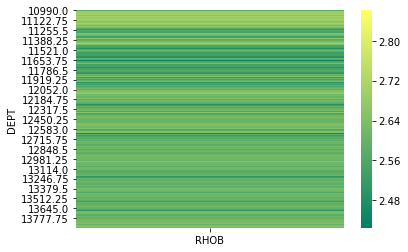

In [166]:
ax = sns.heatmap(df_gr,cmap ="summer", vmin = df_gr.min(),vmax = df_gr.max())

In [57]:
df_gr.head()

,GR
DEPT,
10990.00,28.5660
10990.25,29.0288
10990.50,29.4236
10990.75,30.4836
10991.00,31.6252


In [49]:
sonicdata = pd.read_csv('DTC Range Resources.txt',delimiter="\t", index_col = 'DEPT')

In [50]:
sonicdata = sonicdata[sonicdata.DTC>0]

In [51]:
sonicdata.head()

,DTC
DEPT,
11000.5,64.0521
11100.5,49.2653
11200.5,55.9402
11300.5,63.3536
11400.5,62.9691


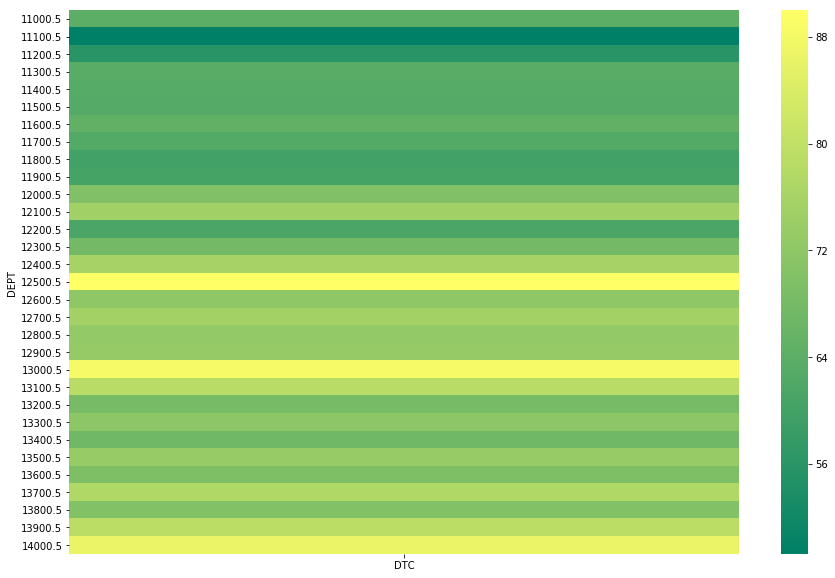

In [162]:
plt.subplots(figsize=(15,10))
ax2 = sns.heatmap(sonicdata,cmap ="summer", vmin = sonicdata.min(),vmax = sonicdata.max())

In [153]:
sonicdata

11300.5

In [138]:
sonicdata.shape
sonicdata.shape[0]
indx_sonic = pd.Series(range(0,sonicdata.shape[0]))
indx_sonic 

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
30    30
dtype: int64

In [152]:
#df1.join(df2, how='outer')
df_gr.iloc[840]

GR    26.2258
Name: 11200.0, dtype: float64

In [62]:
#df_syn = df_gr.join(sonicdata,how = 'outer')

In [216]:
#df_syn['SYN'] = df_syn['GR']*df_syn['DTC']
#df_gr.iloc[2]
df_syn = df_gr.iloc[2]*sonicdata.iloc[3]

df_gr.head()
sonicdata.iloc[3]

,RHOB
DEPT,
10990.00,2.6920
10990.25,2.6952
10990.50,2.6949
10990.75,2.6932
10991.00,2.6955


In [187]:
df_gr.iloc[2]

RHOB    2.6949
Name: 10990.5, dtype: float64

In [248]:
#baba = df_gr.iloc[2] + sonicdata.iloc[3]
#baba = df_gr.loc[:,"RHOB"]+sonicdata.loc[:,"DTC"]
#baba

#df_gr.loc[1,'syn'] = df_gr.loc[10990.25]+df_gr.loc[10990.50]

In [89]:
#ax3 = sns.heatmap(df_syn['SYN'],cmap ="summer", vmin = df_syn['SYN'].min(),vmax = df_syn['SYN'].max())
Depth_gr = df_gr.index

Float64Index([ 10990.0, 10990.25,  10990.5, 10990.75,  10991.0, 10991.25,
               10991.5, 10991.75,  10992.0, 10992.25,
              ...
              13903.75,  13904.0, 13904.25,  13904.5, 13904.75,  13905.0,
              13905.25,  13905.5, 13905.75,  13906.0],
             dtype='float64', name='DEPT', length=11665)

In [243]:
impedance = pd.DataFrame(columns = ['AI'])
fifi = df_gr.loc[10990.50]*sonicdata.index[4]
#fifi ['RHOB']
impedance.loc[4] = fifi ['RHOB']
impedance.head()

,AI
4,30723.20745


In [244]:
counter_gr = 0
counter_sonic = 0
i = 0
AI = 0
impedance = pd.DataFrame(columns = ['AI'])

indx_gr = counter_gr
for indx_gr, value in df_gr.iterrows():
    if indx_gr < sonicdata.index[counter_sonic]:
        #print('value is', value["RHOB"], 'counter_rho is',indx_gr, 'sonic depth is',sonicdata.index[counter_sonic])
        AI = df_gr.loc[indx_gr] *sonicdata.index[counter_sonic]
        impedance.loc[indx_gr] = AI['RHOB']
        #print('impedance is',impedance[indx_gr])
    else: 
        counter_gr = indx_gr
        counter_sonic = counter_sonic + 1
       # print('sonic counter is', counter_sonic, 'new sonic depth is', sonicdata.index[counter_sonic])

In [229]:
#impedance = impedance.to_frame()

In [249]:
#impedance

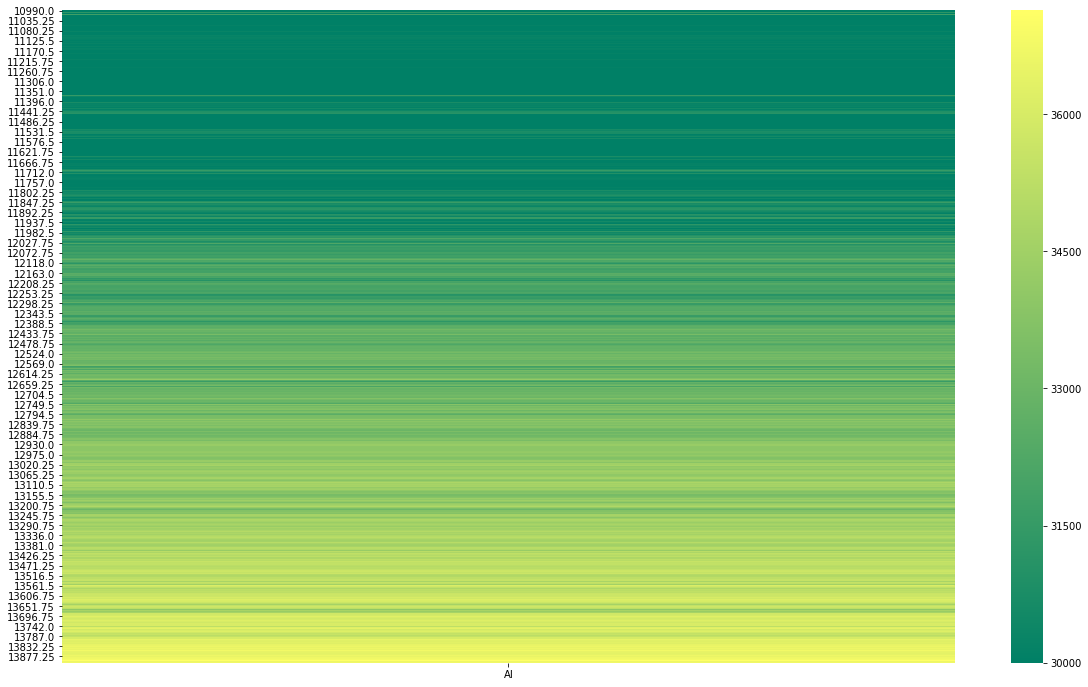

In [259]:
plt.subplots(figsize=(20,12))
ax3 = sns.heatmap(impedance,cmap ="summer", vmin = 30000,vmax = impedance.max())